In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, recall_score, \
    accuracy_score, precision_score, f1_score, plot_confusion_matrix, classification_report, roc_auc_score,\
    plot_roc_curve, plot_precision_recall_curve

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/logistic_model_features.csv", index_col=0)

In [7]:
df.head(2)

,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,NaN,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional


Doing final preparation of data, flattening and converting 

In [8]:
df['permit'] = df['permit'].astype(str)
df['region_code'] = df['region_code'].astype(str)
df['district_code'] = df['district_code'].astype(str)

In [9]:
# Re-filling zeros in amount_tsh

df['amount_tsh'].fillna(0, inplace=True)

In [10]:
ohe = OneHotEncoder(sparse=False)
target = pd.DataFrame(ohe.fit_transform(df[['status_group']]), index=df.index, columns=[
    'Functional', "Needs_Repair", "Non-Functional"])

In [11]:
y_flat = np.argmax(np.array(target), axis=1)

y_flat
dbl_check = pd.Series(y_flat, name='Target')

### After several model iterations, I am going to investigate the data a bit further, and perhaps clean some more columns.

In [13]:
original_features = pd.read_csv('../Data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')

In [14]:
original_features.shape

(59400, 40)

Looking into datetime information.

### Public Meeting, management_group, subvillage,  addition

In [16]:
original_features['subvillage'].value_counts()[55:60]

Mpakani     53
Msufini     52
Dodoma      52
Kaloleni    51
Magomeni    51
Name: subvillage, dtype: int64

In [17]:
to_replace = original_features["subvillage"].value_counts()[
    original_features["subvillage"].value_counts() < 51].index.values

# creating a new dataframe for safety with binned 'subvillage' values
villages =  original_features.replace(to_replace, value="other").copy() 
# villages.value_counts()

In [18]:
original_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [19]:
villages.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,other,other,11,5,other,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,other,other,20,2,other,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,other,Majengo,other,21,4,other,other,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,other,other,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,other,other,18,1,other,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


I am selecting additional features to add to my model. I have now found that the subvillages can be added, but i binned all of the subvillages with fewer than 60 occurences. 

In [548]:
add_features = villages[['id', 'public_meeting', 'management_group', 'subvillage']]

In [549]:
more_features = pd.merge(df, add_features, on='id')

In [550]:
more_features.head(2)

,Unnamed: 0,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,days_passed,public_meeting,management_group,subvillage
0,0,69572,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional,995,True,user-group,other
1,1,8776,0.0,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional,272,NaN,user-group,other


In [579]:
more_features['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

# Datetime conversion

In [437]:
latest_date = pd.to_datetime(original_features['date_recorded']).max()

Created a total of days passed between "date_recorded" and maximum "data_recorded"

In [443]:
df['days_passed'] = abs(pd.to_datetime(original_features['date_recorded']) - latest_date)

In [467]:
df['days_passed'] = df['days_passed'].dt.days

Looking at revising the features i have selected.

In [ ]:
original_features['']

Mine, 'gps_height', 'longitude', 'latitude', ,
       , , , , ,
       'region_code', 'district_code', , ,
       'scheme_name', , , 'management', ,
       , , ,
       ],


Irwin's       'subvillage', , , , , 'public_meeting',
       'recorded_by', , ,,
       , , , , , 'waterpoint_type_group']

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         59400 non-null  int64  
 1   id                 59400 non-null  int64  
 2   amount_tsh         59400 non-null  float64
 3   gps_height         59400 non-null  int64  
 4   longitude          57588 non-null  float64
 5   latitude           59400 non-null  float64
 6   population         38019 non-null  float64
 7   construction_year  38691 non-null  float64
 8   funder             55765 non-null  object 
 9   installer          55745 non-null  object 
 10  basin              59400 non-null  object 
 11  region             59400 non-null  object 
 12  region_code        59400 non-null  object 
 13  district_code      59400 non-null  object 
 14  lga                59400 non-null  object 
 15  ward               59400 non-null  object 
 16  scheme_management  555

After adding this new dates-passed information, i will retest some models. 

In [361]:
df['latitude'].describe()

count    5.940000e+04
mean    -5.706033e+00
std      2.946019e+00
min     -1.164944e+01
25%     -8.540621e+00
50%     -5.021597e+00
75%     -3.326156e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [589]:
dbl_check

0        0
1        0
2        0
3        2
4        0
        ..
59395    0
59396    0
59397    0
59398    0
59399    0
Name: Target, Length: 59400, dtype: int64

In [591]:
pd.concat([more_features.drop(["Unnamed: 0", 'id'], axis=1), dbl_check], axis=1)

,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,days_passed,public_meeting,management_group,subvillage,Target
0,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional,995,True,user-group,other,0
1,0.0,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional,272,NaN,user-group,other,0
2,25.0,686,37.460664,-3.821329,250.0,2009.0,other,dif_other,Pangani,Manyara,21,4,Simanjiro,other,VWC,dif_other,True,gravity,vwc,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,functional,281,True,user-group,Majengo,0
3,0.0,263,38.486161,-11.155298,58.0,1986.0,other,dif_other,Ruvuma / Southern Coast,Mtwara,90,63,other,other,VWC,NaN,True,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional,309,True,user-group,other,2
4,0.0,0,31.130847,-1.825359,NaN,NaN,other,other,dif_other,other,18,1,Karagwe,other,NaN,NaN,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional,874,True,other,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,125.0,1999.0,Germany Republi,CES,Pangani,Kilimanjaro,3,5,Hai,Masama Magharibi,other,Losaa Kia water supply,True,gravity,other,pay per bucket,soft,enough,spring,groundwater,communal standpipe,functional,214,True,user-group,other,0
59396,4700.0,1212,35.249991,-9.070629,56.0,1996.0,other,other,Rufiji,Iringa,11,4,Njombe,other,VWC,Ikondo electrical water sch,True,gravity,vwc,pay annually,soft,enough,river,surface,communal standpipe,functional,941,True,user-group,other,0
59397,0.0,0,34.017087,-8.750434,NaN,NaN,NaN,NaN,Rufiji,Mbeya,12,7,Mbarali,Chimala,VWC,NaN,False,swn 80,vwc,pay monthly,fluoride,enough,machine dbh,groundwater,hand pump,functional,967,True,user-group,other,0
59398,0.0,0,35.861315,-6.378573,NaN,NaN,other,other,Rufiji,Dodoma,1,4,Chamwino,other,VWC,NaN,True,nira/tanira,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump,functional,1001,True,user-group,other,0


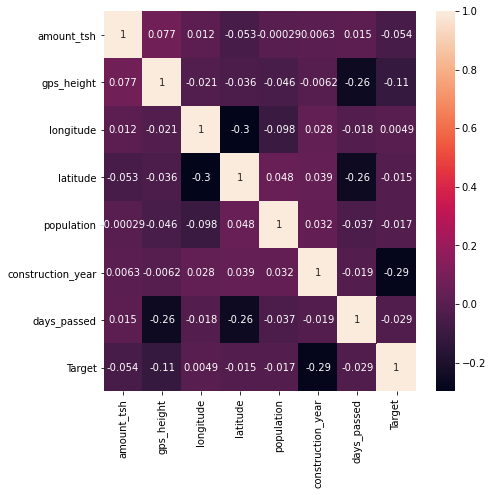

In [597]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(pd.concat([more_features.drop(["Unnamed: 0", 'id'], axis=1), dbl_check], axis=1).corr(), annot=True, ax=ax);

# Assigned values to X and y
### Had been using 'df' as variable, now using 'more_features'

In [553]:
X = more_features.drop(['status_group', 'Unnamed: 0', 'id'], axis=1)
y = dbl_check

In [555]:
y.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
Name: Target, dtype: float64

In [599]:
X.shape

(59400, 29)

In [557]:
X.head(2)

,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,days_passed,public_meeting,management_group,subvillage
0,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,995,True,user-group,other
1,0.0,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,272,NaN,user-group,other


In [558]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [598]:
X_train.shape

(44550, 29)

# Class creation

In [234]:
models = []

In [235]:
class Model():
    model_list = []
    model_df = pd.DataFrame([[0, 0, 0]], columns=["Name", "train_score", "test_score"])
    
    def __init__(self, name, model):
        self.name = name
        self.params = model.get_params
        self.train_score = model.score(X_train, y_train)
        self.test_score = model.score(X_test, y_test)
    
        Model.model_list.append(self)
        attributes = np.array([self.name, self.train_score, self.test_score])
        self.attributes = attributes
        
        self.attributes_df = pd.DataFrame([attributes], columns=['Name', 'train_score', 'test_score'])
        Model.model_df = pd.concat([Model.model_df, self.attributes_df], axis=0)

    @classmethod
    def get_model_list(cls):
        return cls.model_list

# Functions

In [236]:
def catalogue(model, X_train, X_test, y_train, y_test):
    model = Model(model)
    global models
    return model

In [237]:
def record(model, X_train, X_test, y_train, y_test):
    stats = np.array(model.get_params, model.score(X_train, y_train), model.score(X_test, y_test))
    df = pd.DataFrame(stats, columns=["parameters", "train_score", 'test_score'])
    return df

# Pipeline construction

In [611]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44550 entries, 35240 to 49783
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         44550 non-null  float64
 1   gps_height         44550 non-null  int64  
 2   longitude          43195 non-null  float64
 3   latitude           44550 non-null  float64
 4   population         28541 non-null  float64
 5   construction_year  29050 non-null  float64
 6   funder             41815 non-null  object 
 7   installer          41804 non-null  object 
 8   basin              44550 non-null  object 
 9   region             44550 non-null  object 
 10  region_code        44550 non-null  object 
 11  district_code      44550 non-null  object 
 12  lga                44550 non-null  object 
 13  ward               44550 non-null  object 
 14  scheme_management  41626 non-null  object 
 15  scheme_name        23413 non-null  object 
 16  permit            

In [566]:
subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
])

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  # sparse=False in failed version
], verbose=True)  # verbose = False on failed version

In [567]:
CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough', n_jobs= -1)

In [568]:
add_features1 = Pipeline(steps=[
    ('CT', CT),
    ('add_features1', LogisticRegression(max_iter=1000, n_jobs= -1, multi_class="multinomial", 
    solver='newton-cg', tol=.0001, C=0.1))
], verbose=True)

### Reference for hyperparameters

In [569]:
('poly2',
                 LogisticRegression(C=0.1, fit_intercept=False, max_iter=200,
                                    multi_class='multinomial', n_jobs=-1,
                                    solver='newton-cg', tol=0.01))],
         verbose=True)

SyntaxError: unmatched ']' (<ipython-input-569-2b8685ac1879>, line 4)

### Optional Smoting

In [570]:
poly_smote = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy='auto')),
    ('poly_smote', LogisticRegression(n_jobs= -1, C=0.1, max_iter=200, tol=.01, 
        multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

# ACTUAL PIPELINE FITTING! 

In [571]:
add_features1.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=  10.9s
[Pipeline] ..... (step 2 of 2) Processing add_features1, total=  13.9s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff51ba590a0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))

# Instantiation of models

In [572]:
add_features1.score(X_train, y_train), add_features1.score(X_test, y_test)

(0.7686644219977553, 0.7655218855218855)

In [573]:
log_loss = cross_val_score(add_features1, X_train, y_train, scoring='neg_log_loss', n_jobs=-1)

In [575]:
-np.mean(log_loss)

0.5817625801307812

In [308]:
log_model1.train_score, log_model1.train_score
# no real difference, so i will try some other shit

(0.7699214365881033, 0.7699214365881033)

In [483]:
dates = Model("dates1", dates_passed)

In [249]:
model_1.train_score, model_1.test_score

(0.6697418630751965, 0.665050505050505)

In [287]:
log_model1 = Model("Baseline_log", log_model)

In [484]:
Model.model_df

,Name,train_score,test_score
0,0,0,0
0,baseline,0.6697418630751965,0.665050505050505
0,Smote_grid1,0.6697418630751965,0.665050505050505
0,Baseline_log,0.7699214365881033,0.7650505050505051
0,Baseline_log,0.7699214365881033,0.7650505050505051
0,Baseline_log_grid,0.7668462401795735,0.7647811447811448
0,poly1,0.7724354657687991,0.7688215488215489
0,Poly_grid_1,0.7724354657687991,0.7688215488215489
0,poly2,0.7701683501683502,0.7661279461279461
0,Poly_grid_3,0.7724354657687991,0.7688215488215489


In [600]:
for i in add_features1.get_params().keys():
    print(i)

memory
steps
verbose
CT
add_features1
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_imp

In [397]:
# poly_model2.get_params

In [602]:
params = {
    'add_features1__solver' : ['newton-cg'],  # 'newton-cholesky' not supported in logistic regression
    'add_features1__max_iter': [800, 700, 600, 500],
    'add_features1__C' : [0.01, .1, .001, 1],
    'add_features1__tol' : [.01, .1, .001],
    "add_features1__penalty" : ['l1', 'l2', 'elasticnet', 'none']
}

In [603]:
gs = GridSearchCV(
    estimator= add_features1,     # Subset pipeline
    param_grid=params,
    cv=5,
    verbose=2,
    n_jobs=-1)

In [604]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 77.4min


KeyboardInterrupt: 

In [489]:
gs.best_estimator_

Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff51d0332b0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_i...
                                               

In [490]:
gs.best_params_

{'dates__C': 1,
 'dates__max_iter': 200,
 'dates__solver': 'newton-cg',
 'dates__tol': 0.01}

In [491]:
dates = gs.best_estimator_
dates.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 2) Processing dates, total= 1.1min


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff51d0332b0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_i...
                                               

In [404]:
# poly_3_grid

In [492]:
dates.score(X_train, y_train), dates.score(X_test, y_test)

(0.7722558922558923, 0.7679461279461279)

In [493]:
dates_grid = Model("Dates_grid", dates)

In [494]:
print(classification_report(y_test, dates.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      8065
           1       0.53      0.18      0.27      1079
           2       0.80      0.71      0.75      5706

    accuracy                           0.77     14850
   macro avg       0.70      0.59      0.61     14850
weighted avg       0.76      0.77      0.75     14850



In [495]:
Model.model_df

,Name,train_score,test_score
0,0,0,0
0,baseline,0.6697418630751965,0.665050505050505
0,Smote_grid1,0.6697418630751965,0.665050505050505
0,Baseline_log,0.7699214365881033,0.7650505050505051
0,Baseline_log,0.7699214365881033,0.7650505050505051
0,Baseline_log_grid,0.7668462401795735,0.7647811447811448
0,poly1,0.7724354657687991,0.7688215488215489
0,Poly_grid_1,0.7724354657687991,0.7688215488215489
0,poly2,0.7701683501683502,0.7661279461279461
0,Poly_grid_3,0.7724354657687991,0.7688215488215489


In [613]:
for i in Model.model_list:
    print(i.name)

baseline
Smote_grid1
Baseline_log
Baseline_log
Baseline_log_grid
poly1
Poly_grid_1
poly2
Poly_grid_3
poly_smote
dates1
Dates_grid


In [622]:
Model.model_list[5].train_score

0.7724354657687991

In [623]:
Model.model_list[5].params

<bound method Pipeline.get_params of Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff51d5101f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                 

In [624]:
Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/abridged_table.csv')

In [610]:
baseline = Model.model_list[0]
baseline.params

<bound method Pipeline.get_params of Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff59f4e14f0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,...
                                                                              

# Observations:
- Changing sampling strategy to "auto" made no difference in SMOTE hyperparameters.
- Baseline log grid slightly worse than the uncalibrated logistic regression
- For polynomial features, the grid search did not improve the default settings at all, still not overfit
- After a 2 hour grid search, the best model only equals the best score thus far, still without overfitting, but without any improvement either.
- Polynomial degree 2 + smote improved upon the baseline smote, but still performed worse than other models
# I will revisit the model features in the morning
- Adding the dates_passed column improved the model very slightly. I will now re-check cleaning/feature selection.

In [ ]:


class ModelsList():
    def init(self, x,y):
        xtrain, xtest, ytrain, ytest = train_test_split(x,y)
        self.xtrain = xtrain
        self.xtest = xtest
        self.ytrain = ytrain
        self.ytest = ytest
        self.df = pd.DataFrame({'Model' : pd.Series(dtype='str'), 
                    'train_score' : pd.Series(dtype='float64'), 
                    'test_score': pd.Series(dtype='float64'),
                    'params': pd.Series(dtype='O')})

    def update(self, estimator, name, fit = True, params = None):
        if fit:
            estimator.fit(self.xtrain, self.ytrain)

        trainscore = estimator.score(self.xtrain, self.ytrain)
        testscore = estimator.score(self.xtest, self.ytest)
        model_to_add = [name, trainscore, testscore, params]
        self.df.loc[len(self.df.index)] = model_to_add